## Chapter 1: [Introduction](Introduction.ipynb)

<hr style="height:1px;border-top:4px solid #FF8200" />

# Open DM3 Images, Spectra, Spectrum-Images and  Image-Stacks with PyUSID 


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes



Reading a dm file and translating the data in a **[pyUSID](https://pycroscopy.github.io/pyUSID/)** style hf5py file to be compatible with  the **[pycroscopy](https://pycroscopy.github.io/pycroscopy/)** package.

## First, we load the necessary packages
Please visit the  section for [pyTEMlib](CH1-Prerequesites.ipynb#TEM-Library) of the [Prerequesites](CH1-Prerequesites.ipynb) section for information of necessary packages.

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt

# import TEMlib from pyTEM
import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.KinsCat  as ks
     # File input/ output library
import pyTEMlib.image_tools  as it

# import packages for pyUSID
import pyUSID as usid
import h5py

# For archiving reasons it is a good idea to print the version numbers out at this point
__notebook__='CH1-pyUSID'
__notebook_version__='v1'
print('pyUSID version: ',usid.__version__)
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__='CH1-pyUSID'
__notebook_version__='2019_05_02'


Populating the interactive namespace from numpy and matplotlib
windows
Using KinsCat library version  0.5  by G.Duscher
Symmetry functions of spglib enabled
pyUSID version:  0.0.4
pyTEM version:  0.5.2019


# Open a file 

This function opens a hfd5 file in the pyUSID style which enables you to keep track of your data anlysis.

Please see the **[Installation](CH1-Prerequesites.ipynb#TEM-Library)** for installation.

We want to consolidate files into one dataset that belongs together.  For example a spectrum image dataset consists of: 
* Survey image, 
* EELS spectra 
* Z-contrast image acquired simulatonioulsy with the spectra.


So load the top dataset first in the above example the survey image.

Please note that the plotting routine was introduced in **[Plotting](CH1-Prerequisites.ipynb#Accessing-Data-and-Plotting)**

**Use the file p1-3hr.dm3 from TEM_data directory for a practice run**

dict_keys(['exposure_spectrum', 'number_of_frames', 'collection_angle', 'convergence_angle', 'acceleration_voltage', 'image_type', 'camera_length', 'integration_time', 'time_last_modified'])


<IPython.core.display.Javascript object>


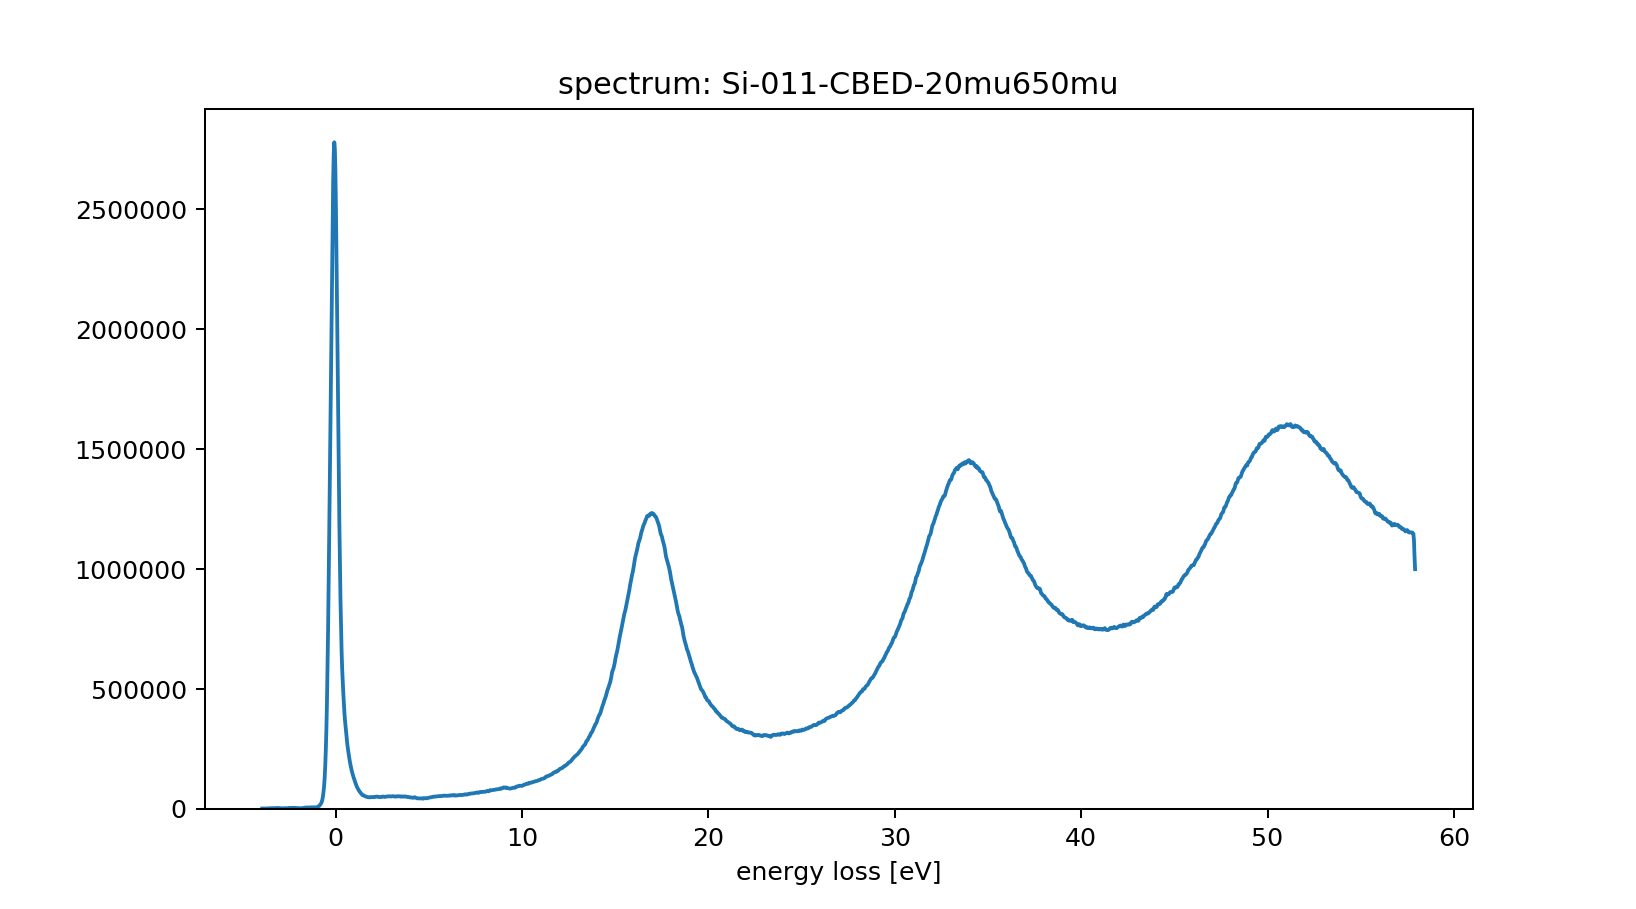

In [13]:
# Load file
h5_file.close()
h5_file = ft.h5open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']

# Create new Figure with black background
fig = plt.figure(figsize=(9,5))

# Add a subplot with no frame
ax = plt.subplot(111)

ft.plt_pyUSID(current_channel,ax)


# Get Data into Dictionary

For small data sizes the python dictionary is the most convenient pythonic data format.

In [12]:
tags = ft.get_dictionary_from_pyUSID(current_channel)
print(tags.keys())

dict_keys(['exposure_spectrum', 'number_of_frames', 'collection_angle', 'convergence_angle', 'acceleration_voltage', 'image_type', 'camera_length', 'integration_time', 'time_last_modified', 'data_type', 'data', 'dispersion', 'units', 'offset', 'spectrum_length', 'energy_scale'])


# Adding Data

To add another dataset that belongs to this measurement we will use the **h5add_channel** from  **filetools** in the  pyTEMlib package.

Here is how we add a channel there.

We can also add a new measurement group (add_measurement in pyTEMlib) for similar datasets.

In [3]:
measurement_group = h5_file[current_channel.name.split('/')[1]]
name = usid.io.hdf_utils.assign_group_index(measurement_group,'Channel')
    
additional_channel = measurement_group.create_group(name)


new_measurement_group = usid.io.hdf_utils.create_indexed_group(h5_file,'Measurement')


usid.hdf_utils.print_tree(h5_file)

print(dict())

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ data_type
    ├ original_metadata
      -----------------
    ├ spatial_origin_x
    ├ spatial_scale_x
    ├ spatial_size_x
    ├ spatial_units
    ├ spectral_origin_x
    ├ spectral_scale_x
    ├ spectral_size_x
    ├ spectral_units_x
    ├ title
  ├ Channel_001
    -----------
├ Measurement_001
  ---------------


## Adding additional information

Similarly we can add a whole new measurement group or a structure group.

This function will be contained in the KinsCat package of pyTEMlib.

If you loaded the example image, with graphite and ZnO both are viewed in the [1,1,1] zone axis.


In [4]:
def h5_add_crystal_structure(h5_file, crystal_tags):
    structure_group = usid.io.hdf_utils.create_indexed_group(h5_file,'Structure')
    
    structure_group['unit_cell'] = crystal_tags['unit_cell']
    structure_group['relative_positions'] = crystal_tags['base']
    structure_group['title'] = str(crystal_tags['crystal_name'])
    structure_group['_'+crystal_tags['crystal_name']] = str(crystal_tags['crystal_name'])
    structure_group['elements'] = np.array(crystal_tags['elements'],dtype='S')
    if 'zone_axis' in structure_group:
        structure_group['zone_axis'] = np.array(crystal_tags['zone_axis'], dtype=float)
    else:
        structure_group['zone_axis'] = np.array([1.,1.,1.], dtype=float)
        
    h5_file.flush()
    return structure_group
                                                                                 
crystal_tags = ks.structure_by_name(h5_file, 'Graphite')
h5_add_crystal_structure(h5_file, crystal_tags)
                                                                                
crystal_tags = ks.structure_by_name(h5_file, 'ZnO')
h5_add_crystal_structure(h5_file, crystal_tags)

usid.hdf_utils.print_tree(h5_file)


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ data_type
    ├ spatial_origin_x
    ├ spatial_origin_y
    ├ spatial_scale_x
    ├ spatial_scale_y
    ├ spatial_size_x
    ├ spatial_size_y
    ├ spatial_units
    ├ title
  ├ Channel_001
    -----------
├ Measurement_001
  ---------------
├ Structure_000
  -------------
  ├ _Graphite
  ├ elements
  ├ relative_positions
  ├ title
  ├ unit_cell
  ├ zone_axis
├ Structure_001
  -------------
  ├ _ZnO Wurzite
  ├ elements
  ├ relative_positions
  ├ title
  ├ unit_cell
  ├ zone_axis


## Keeping Track of Analysis and Results
A notebook is notorious for getting confusing, especially if one uses different notebooks for different task, but store them in the same file.

If you like a result of your calculation, log it.
|
The function will write your calculation to the pyUSID style file and attaches a time stamp.

The two functions below are part of  file_tools of pyTEMlib.

In [5]:
def h5_add_Data2Log(log_group, name, info_dictionary):
    for key in info_dictionary:
        log_group[key] = info_dictionary[key]
def h5_add_Log(current_channel, name):
    log_group = usid.io.hdf_utils.create_indexed_group(current_channel,'Log')
    log_group['title'] = name
    log_group['_'+name] = name ## just easier to read the file-tree that way 
    log_group['time_stamp']= usid.io.io_utils.get_time_stamp()
    try:
        log_group['notebook'] = __notebook__
        log_group['notebook_version'] = __notebook_version__
    except:
        pass
    return log_group

log_group = h5_add_Log(current_channel, 'test')

usid.hdf_utils.print_tree(h5_file)


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ _test
      ├ notebook
      ├ notebook_version
      ├ time_stamp
      ├ title
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ data_type
    ├ spatial_origin_x
    ├ spatial_origin_y
    ├ spatial_scale_x
    ├ spatial_scale_y
    ├ spatial_size_x
    ├ spatial_size_y
    ├ spatial_units
    ├ title
  ├ Channel_001
    -----------
├ Measurement_001
  ---------------
├ Structure_000
  -------------
  ├ _Graphite
  ├ elements
  ├ relative_positions
  ├ title
  ├ unit_cell
  ├ zone_axis
├ Structure_001
  -------------
  ├ _ZnO Wurzite
  ├ elements
  ├ relative_positions
  ├ title
  ├ unit_cell
  ├ zone_axis


## An example for a log
We log the Fourier Transform of the image we loaded

First we perform the calculation

<IPython.core.display.Javascript object>


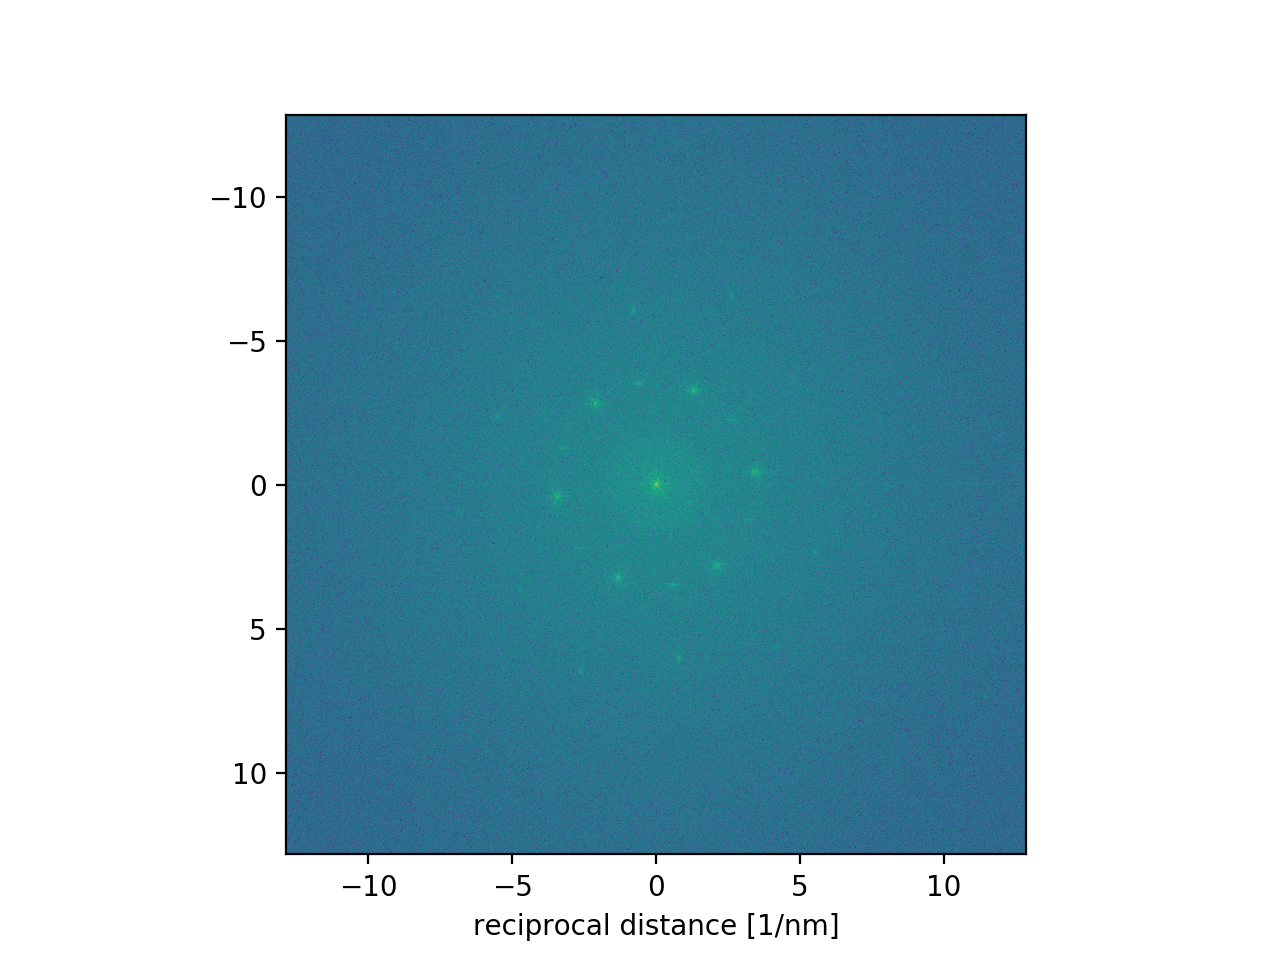

In [6]:
## Access the data of the loaded image
data = current_channel['Raw_Data'][()]
data = np.reshape(data, [current_channel['spatial_size_x'][()], current_channel['spatial_size_y'][()]])

## The data log goes in the dictionary out_tags
out_tags = {}
## data tag contains the newly calculated result
out_tags['data'] = np.fft.fftshift(np.fft.fft2(data))

## meta data (can be anything, but good practice is to be compatible with pyUSID data set)
out_tags['analysis']= 'Fourier_Transform'

out_tags['spatial_origin_x'] = data.shape[0]/2
out_tags['spatial_origin_y'] = data.shape[1]/2

out_tags['spatial_scale_x'] = 1.0/current_channel['spatial_scale_x'][()]/data.shape[0]
out_tags['spatial_scale_y'] = 1.0/current_channel['spatial_scale_x'][()]/data.shape[1]
out_tags['spatial_size_x'] = data.shape[0]
out_tags['spatial_size_y'] = data.shape[1]
out_tags['spatial_units'] = '1/nm'


FOV_x = out_tags['spatial_origin_x']* out_tags['spatial_scale_x']
FOV_y = out_tags['spatial_origin_y']* out_tags['spatial_scale_y']
out_tags['extent'] = [-FOV_x,FOV_x,FOV_y, -FOV_y]
fig = plt.figure()
plt.imshow(np.log2(1+np.abs(out_tags['data'])),origin='upper', extent = out_tags['extent'])
plt.xlabel('reciprocal distance ['+ out_tags['spatial_units']+']');


Now that we like this we log it.

Please note that just saving the fourier transform would not be good as we also need the scale and such.

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ _test
      ├ notebook
      ├ notebook_version
      ├ time_stamp
      ├ title
    ├ Log_001
      -------
      ├ _fft
      ├ analysis
      ├ data
      ├ extent
      ├ notebook
      ├ notebook_version
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ time_stamp
      ├ title
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ data_type
    ├ spatial_origin_x
    ├ spatial_origin_y
    ├ spatial_scale_x
    ├ spatial_scale_y
    ├ spatial_size_x
    ├ spatial_size_y
    ├ spatial_units
    ├ title
  ├ Channel_001
    -----------
├ Measurement_001
  ---------------
├ Structure_000
  -------------
  ├ _Graphite
  ├ elements
  ├ relative_positions
  ├ title
  ├ unit_cell
  ├ zone_axis
├ S

<IPython.core.display.Javascript object>


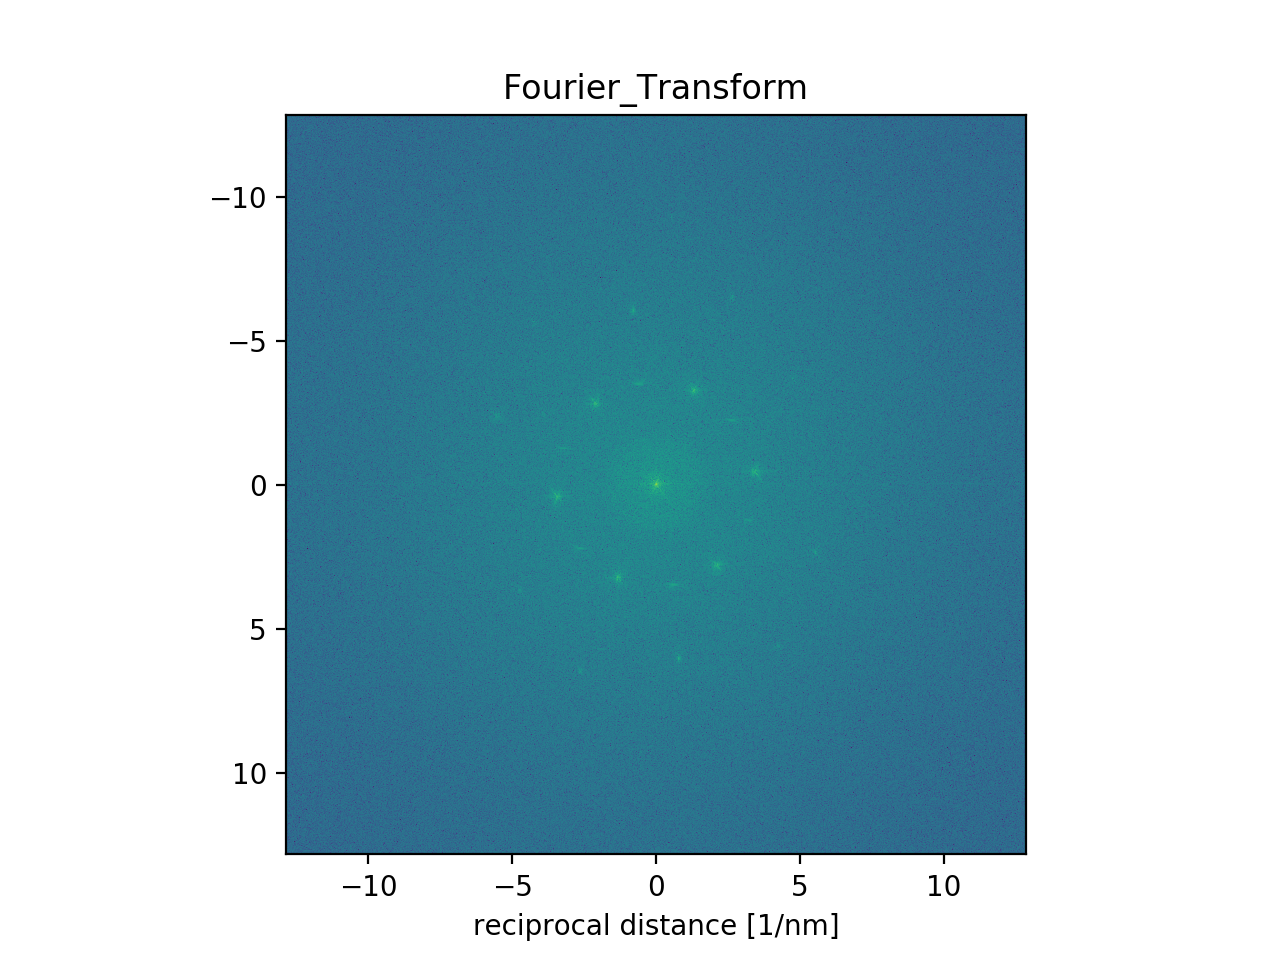

In [7]:

log_group = h5_add_Log(current_channel, 'fft')
h5_add_Data2Log(log_group, name, out_tags)


usid.hdf_utils.print_tree(h5_file)

fig = plt.figure()
plt.title(log_group['analysis'][()])
plt.imshow(np.log2(1+np.abs(log_group['data'][()])),origin='upper', extent = log_group['extent'][()])
plt.xlabel('reciprocal distance ['+ log_group['spatial_units'][()]+']');


Please close the file

In [8]:
h5_file.close()

## Open h5_file
Open the h5_file that we just created

<IPython.core.display.Javascript object>


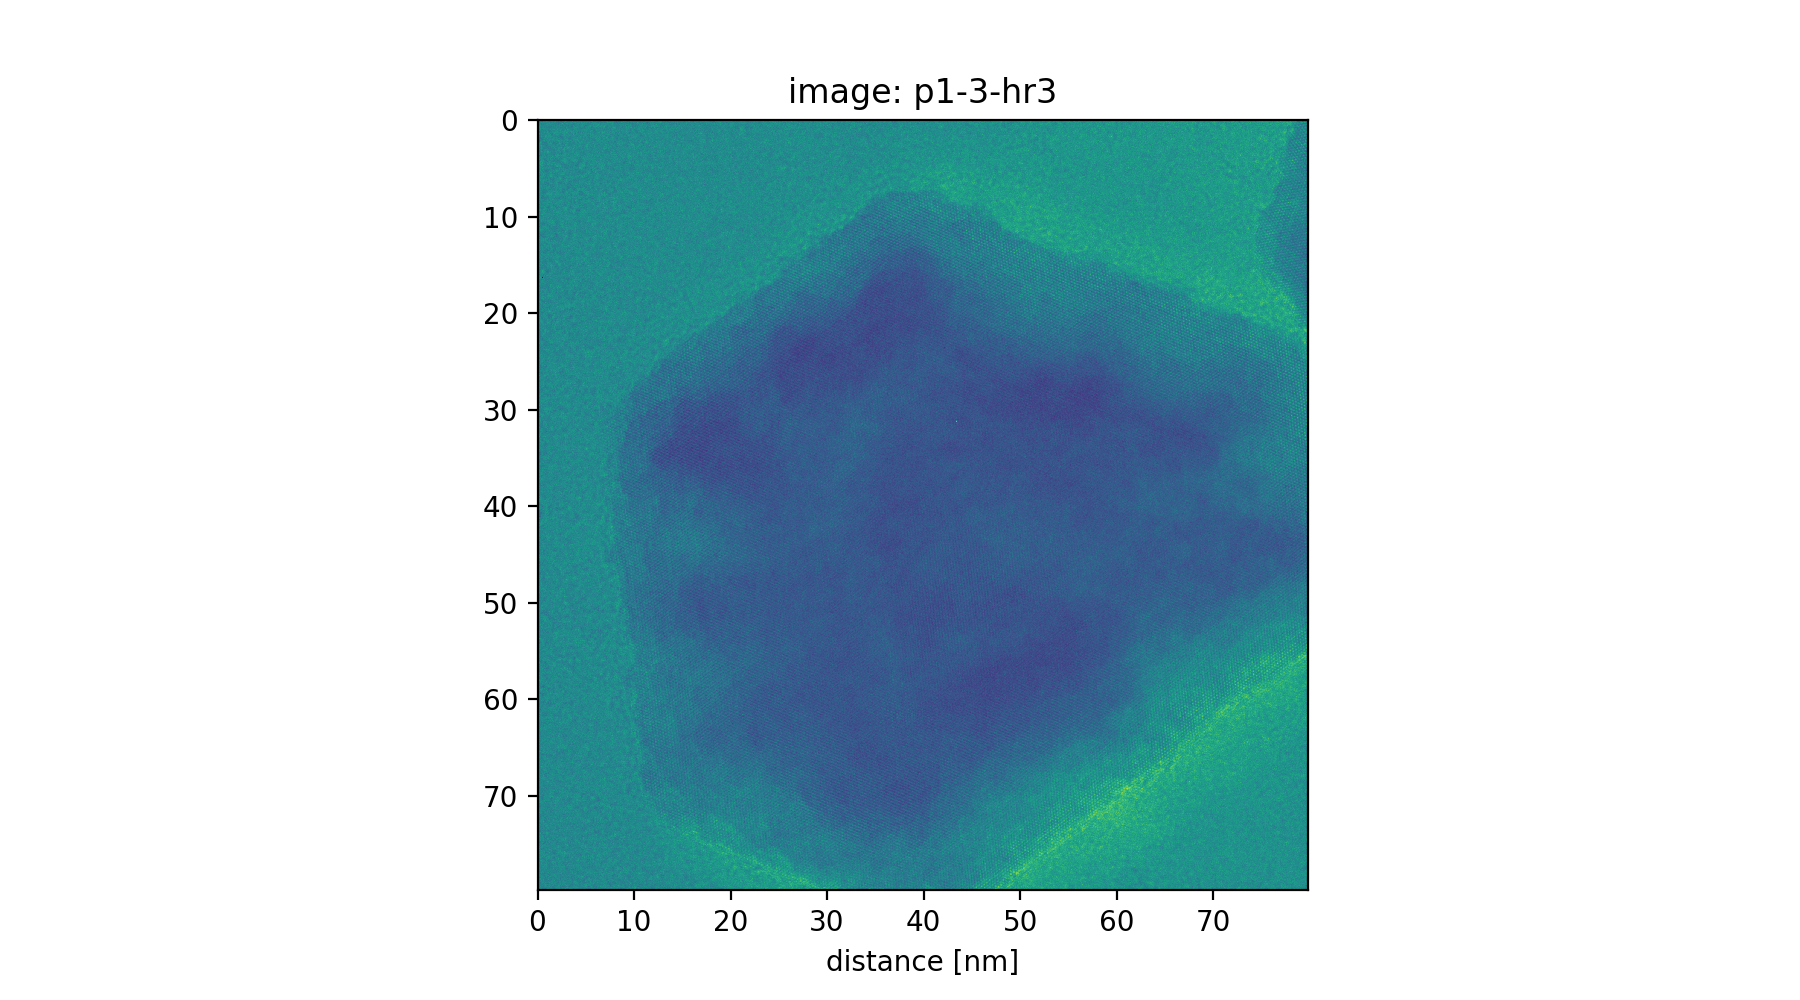

In [10]:
h5_file = ft.h5open_file()

current_channel = h5_file['Measurement_000/Channel_000']

# Create new Figure with black background
fig = plt.figure(figsize=(9,5))

# Add a subplot with no frame
ax = plt.subplot(111)

ft.plt_pyUSID(current_channel,fig,ax)


# Short check if we got the data right
we print the tree and we plot the data

In [11]:
# See if a tree has been created within the hdf5 file:
usid.hdf_utils.print_tree(h5_file)
image_tags = dict(h5_file['Measurement_000/Channel_000'].attrs)
for key in image_tags:
    if 'original' not in key:
        #print(key,': ',image_tags[key])
        pass
current_channel = h5_file['Measurement_000/Channel_000']



/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ _test
      ├ notebook
      ├ notebook_version
      ├ time_stamp
      ├ title
    ├ Log_001
      -------
      ├ _fft
      ├ analysis
      ├ data
      ├ extent
      ├ notebook
      ├ notebook_version
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ time_stamp
      ├ title
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ data_type
    ├ spatial_origin_x
    ├ spatial_origin_y
    ├ spatial_scale_x
    ├ spatial_scale_y
    ├ spatial_size_x
    ├ spatial_size_y
    ├ spatial_units
    ├ title
  ├ Channel_001
    -----------
├ Measurement_001
  ---------------
├ Structure_000
  -------------
  ├ _Graphite
  ├ elements
  ├ relative_positions
  ├ title
  ├ unit_cell
  ├ zone_axis
├ S

## Add more data to this set

Often more than one data set belong together.
For instance a spectrum image has a survey image and a Z-contrast image recorded with the survey image.

Here we jsut load another image for example *p1-3-hr3b.dm3*

In [13]:
current_channel = ft.h5add_channels(h5_file,current_channel,'spectrum image')
    
measurement_group = h5_file[current_channel.name.split('/')[1]]
    
for key in list(measurement_group.keys()):
    if 'title' in measurement_group[key].keys(): 
        print(key,': ',measurement_group[key]['title'][()])
    else:
        print(key,': ')   

Channel_000 :  p1-3-hr3
Channel_001 : 
Channel_002 :  p1-3-hr3b
Channel_003 :  p1-3-hr3b


Let's see what you selected


<IPython.core.display.Javascript object>


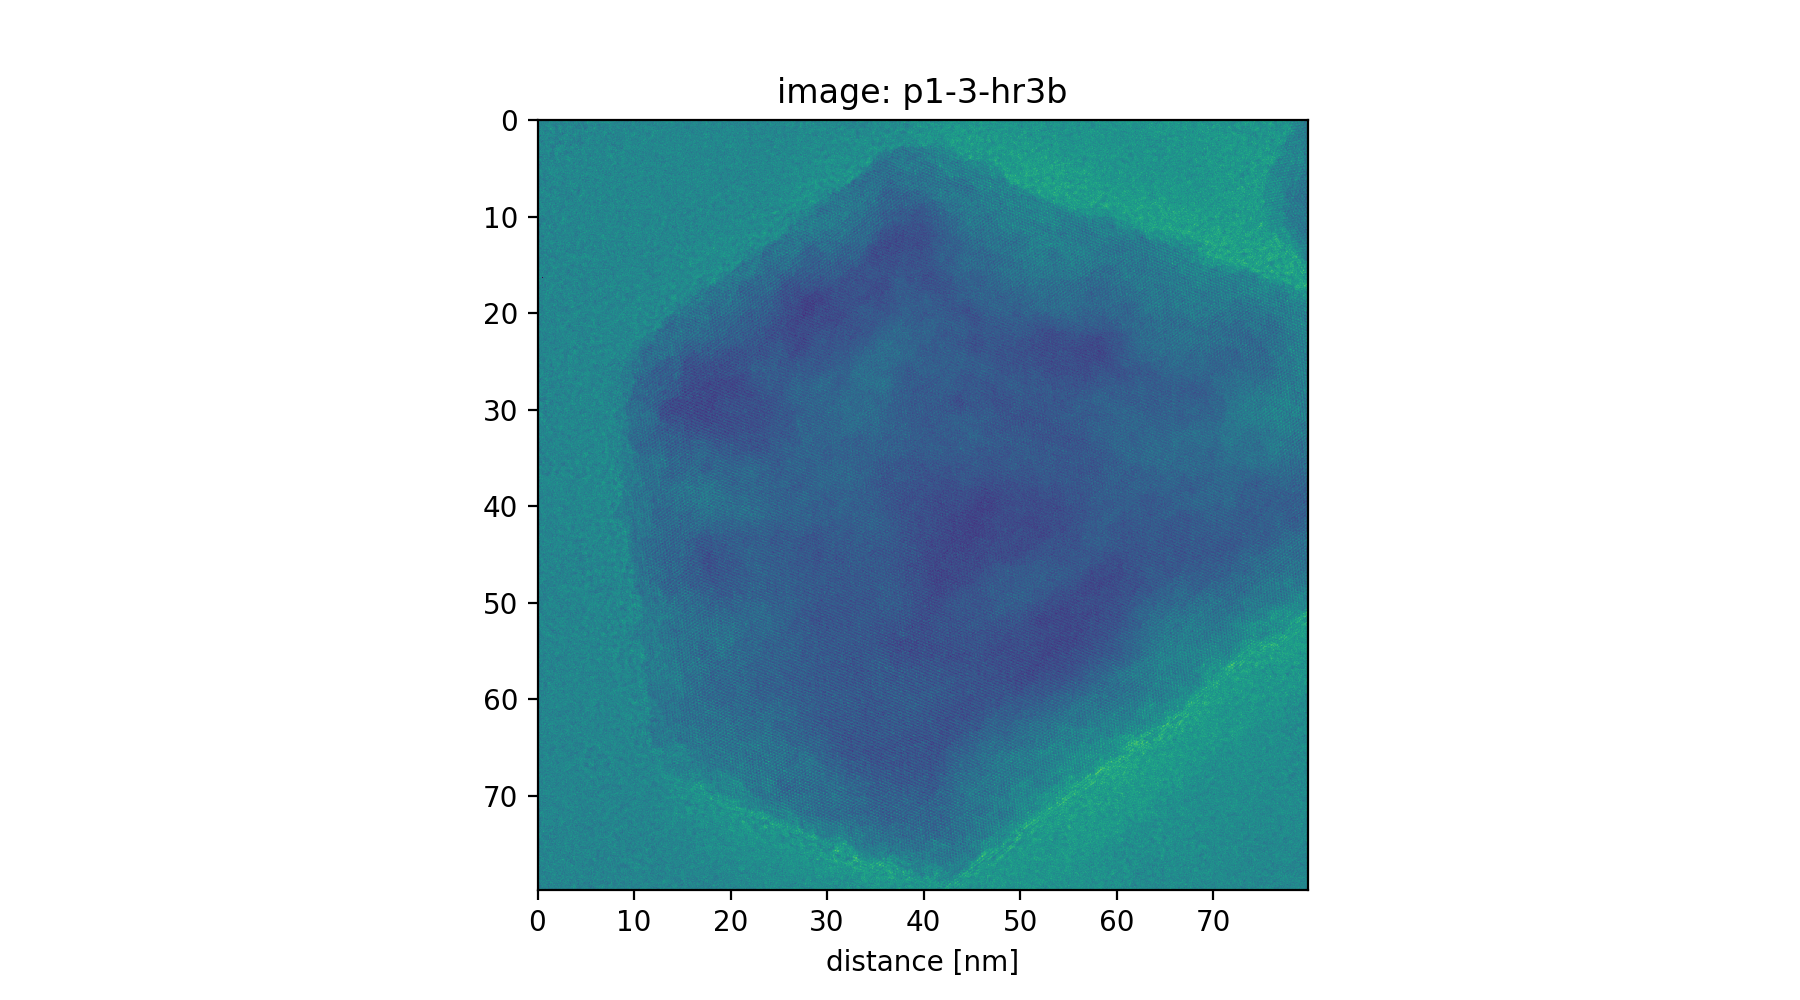

In [14]:
# Create new Figure with black background
fig = plt.figure(figsize=(9,5))

# Add a subplot with no frame
ax = plt.subplot(111)

ft.plt_pyUSID(current_channel,fig,ax)

## If we are done, we close the pyUID style file.

This is necessary to make the file ready to be opened by another notebook or program.

In [15]:
h5_file.close()

### Appendix: code for the log of calculation

In [ ]:
def h5log_calculation(h5_file,current_channel,tags):
    measurement_group = h5_file[current_channel.name.split('/')[1]]
    i = 0
    for key in measurement_group:
        if 'Calculation'in key:
            i+=1
    name = f'Calculation_{i:03d}'
    if 'data' not in tags:
        print('no data to log')
        return
    
    calc_grp = measurement_group.create_group(name)
    calc_grp['time_stamp']= usid.io.io_utils .get_time_stamp()
    for key in tags:
        calc_grp[key]= tags[key]
    return calc_grp

